# Day 3: Data augementation 

Purpose of this notebook is to train a model with data augmentation. I will be using best parameters from previous notebook and will be using data augmentation to improve the model.
* make sweep with different data augementation types
* make seperate training file but do preprocessing, visualization and post processing in this file
* make a seperate file for model training
* make utility library for common functions and install with pip 

Imports:

In [1]:
import MyUtils.Util.Misc as util


2024-05-18 17:23:14.466485: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-18 17:23:15.415590: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import keras
import numpy as np
import tensorflow as tf
import os
import wandb
import matplotlib.pyplot as plt
import IPython.display as display
import gc
import pandas as pd
import kaggle
import torch
import zipfile
from sklearn.model_selection import train_test_split
from omegaconf import OmegaConf
from keras import layers
import time

Check GPU:

In [3]:
# throw error if no gpu available
assert torch.cuda.is_available(), "No GPU available"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Cofiguration

In [4]:
cfg = util.load_and_override_config(".", "config")

cfg: 
 {'project_name': 'Day3', 'username': 'frizzerdk', 'is_sweep': False, 'sweep_count': 1, 'preprocessed_data_path': './data/preprocessed', 'x_train_path': '${preprocessed_data_path}/x_train.npy', 'y_train_path': '${preprocessed_data_path}/y_train.npy', 'x_test_path': '${preprocessed_data_path}/x_test.npy', 'x_val_path': '${preprocessed_data_path}/x_val.npy', 'y_val_path': '${preprocessed_data_path}/y_val.npy', 'checkpoint_path': './checkpoints', 'best_model_path': '${checkpoint_path}/best_model.keras', 'num_classes': 10, 'input_shape': [28, 28, 1], 'activation': 'relu', 'epochs': 2, 'param_scale': 2.0, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64, 'patience': 20, 'data_augmentation': {'layers': {'RandomTranslation': {'kwargs': {'height_factor': 0.0, 'width_factor': 0.0, 'fill_mode': 'constant'}}, 'RandomRotation': {'kwargs': {'factor': 0.0, 'fill_mode': 'constant'}}, 'RandomZoom': {'kwargs': {'height_factor': 0.0, 'width_factor': 0.0, 'fill_mode': 'constant'}}, 'Ra

## Get data ready

dowload data and unzip it

In [5]:
# Define the directory where you want to download the data
data_dir = "MyDataset/mnist/raw"  # './' represents the current directory

# Check if the directory exists
if not os.path.exists(data_dir):
    # If not, create the directory
    os.makedirs(data_dir)

# Move to that directory
os.chdir(data_dir)
competition_name = "digit-recognizer"
# Download the data
os.system("kaggle competitions download -c " + competition_name)

# Unzip the data
with zipfile.ZipFile("digit-recognizer.zip","r") as zip_ref:
    zip_ref.extractall(".")

os.chdir("../../..")

digit-recognizer.zip: Skipping, found more recently modified local copy (use --force to force download)


Load data

In [6]:
# Load the dataset
train_df = pd.read_csv('MyDataset/mnist/raw/train.csv')
test_df = pd.read_csv('MyDataset/mnist/raw/test.csv')

# Split features and labels
y_train = train_df["label"]
x_train = train_df.drop(labels = ["label"], axis = 1)

# Convert to numpy arrays
x_train = x_train.values
y_train = y_train.values

# Test data
x_test = test_df.values

Inspect raw data

In [7]:
train_df.head()




,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Prepare data

In [8]:
# split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=2)

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (37800, 28, 28, 1)
y_train shape: (37800,)
37800 train samples
28000 test samples


Show preprocessed data

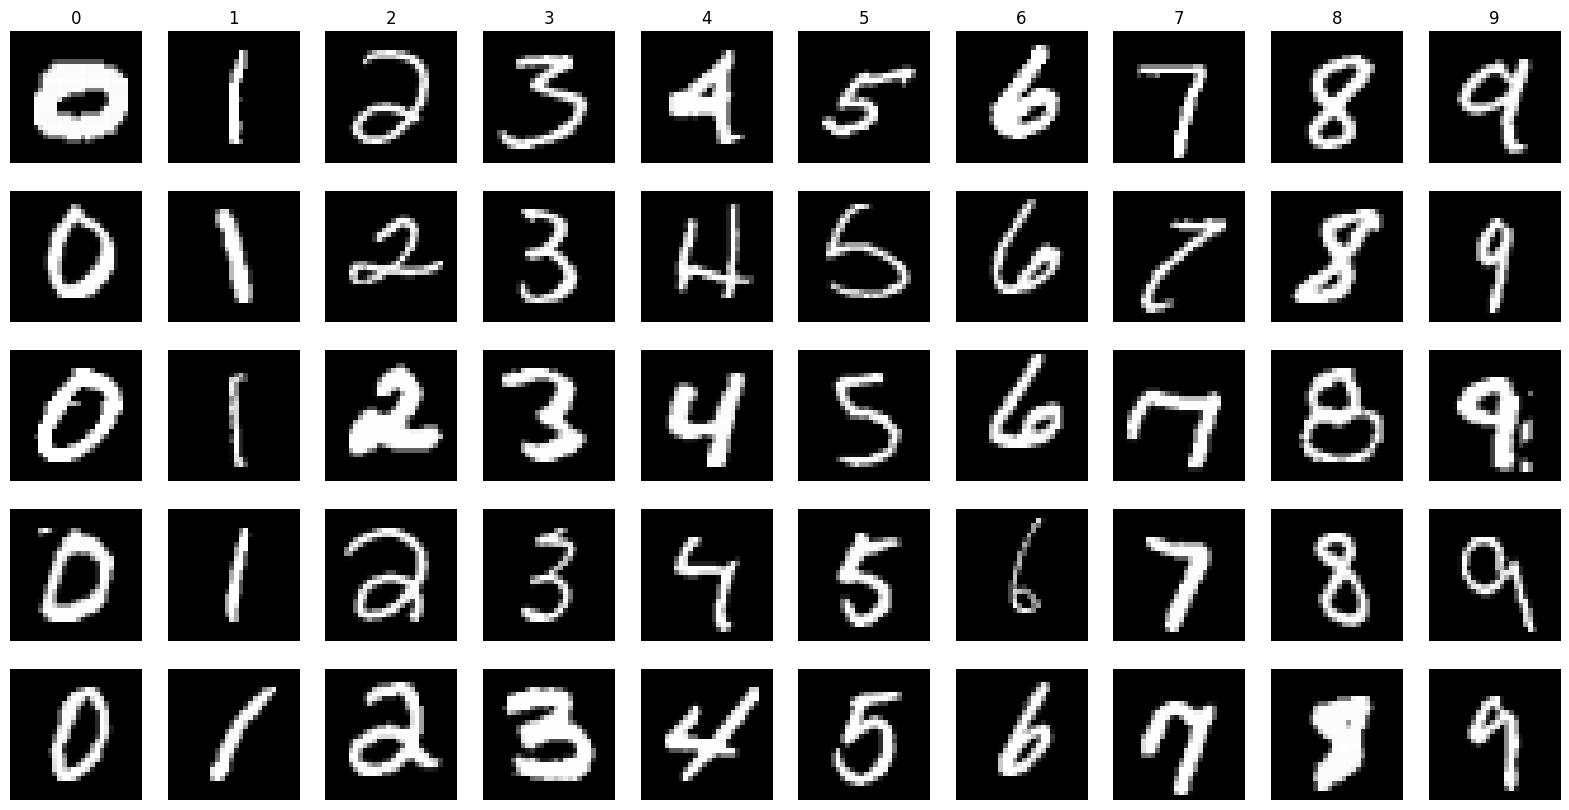

In [9]:
# Show 5 samples from each class
classes = np.unique(y_train)
n_classes = len(classes)
samples_per_class = 5

plt.figure(figsize=(20, 10))
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * n_classes + y + 1
        plt.subplot(samples_per_class, n_classes, plt_idx)
        plt.imshow(x_train[idx].reshape(28, 28), cmap='gray')
        plt.axis("off")
        if i == 0:
            plt.title(cls)



Show augmented examples

cfg: 
 {'project_name': 'Day3', 'username': 'frizzerdk', 'is_sweep': False, 'sweep_count': 1, 'preprocessed_data_path': './data/preprocessed', 'x_train_path': '${preprocessed_data_path}/x_train.npy', 'y_train_path': '${preprocessed_data_path}/y_train.npy', 'x_test_path': '${preprocessed_data_path}/x_test.npy', 'x_val_path': '${preprocessed_data_path}/x_val.npy', 'y_val_path': '${preprocessed_data_path}/y_val.npy', 'checkpoint_path': './checkpoints', 'best_model_path': '${checkpoint_path}/best_model.keras', 'num_classes': 10, 'input_shape': [28, 28, 1], 'activation': 'relu', 'epochs': 2, 'param_scale': 2.0, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64, 'patience': 20, 'data_augmentation': {'layers': {'RandomTranslation': {'kwargs': {'height_factor': 0.0, 'width_factor': 0.0, 'fill_mode': 'constant'}}, 'RandomRotation': {'kwargs': {'factor': 0.0, 'fill_mode': 'constant'}}, 'RandomZoom': {'kwargs': {'height_factor': 0.0, 'width_factor': 0.0, 'fill_mode': 'constant'}}, 'Ra

2024-05-18 17:23:25.598767: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-18 17:23:25.599890: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-18 17:23:25.600101: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

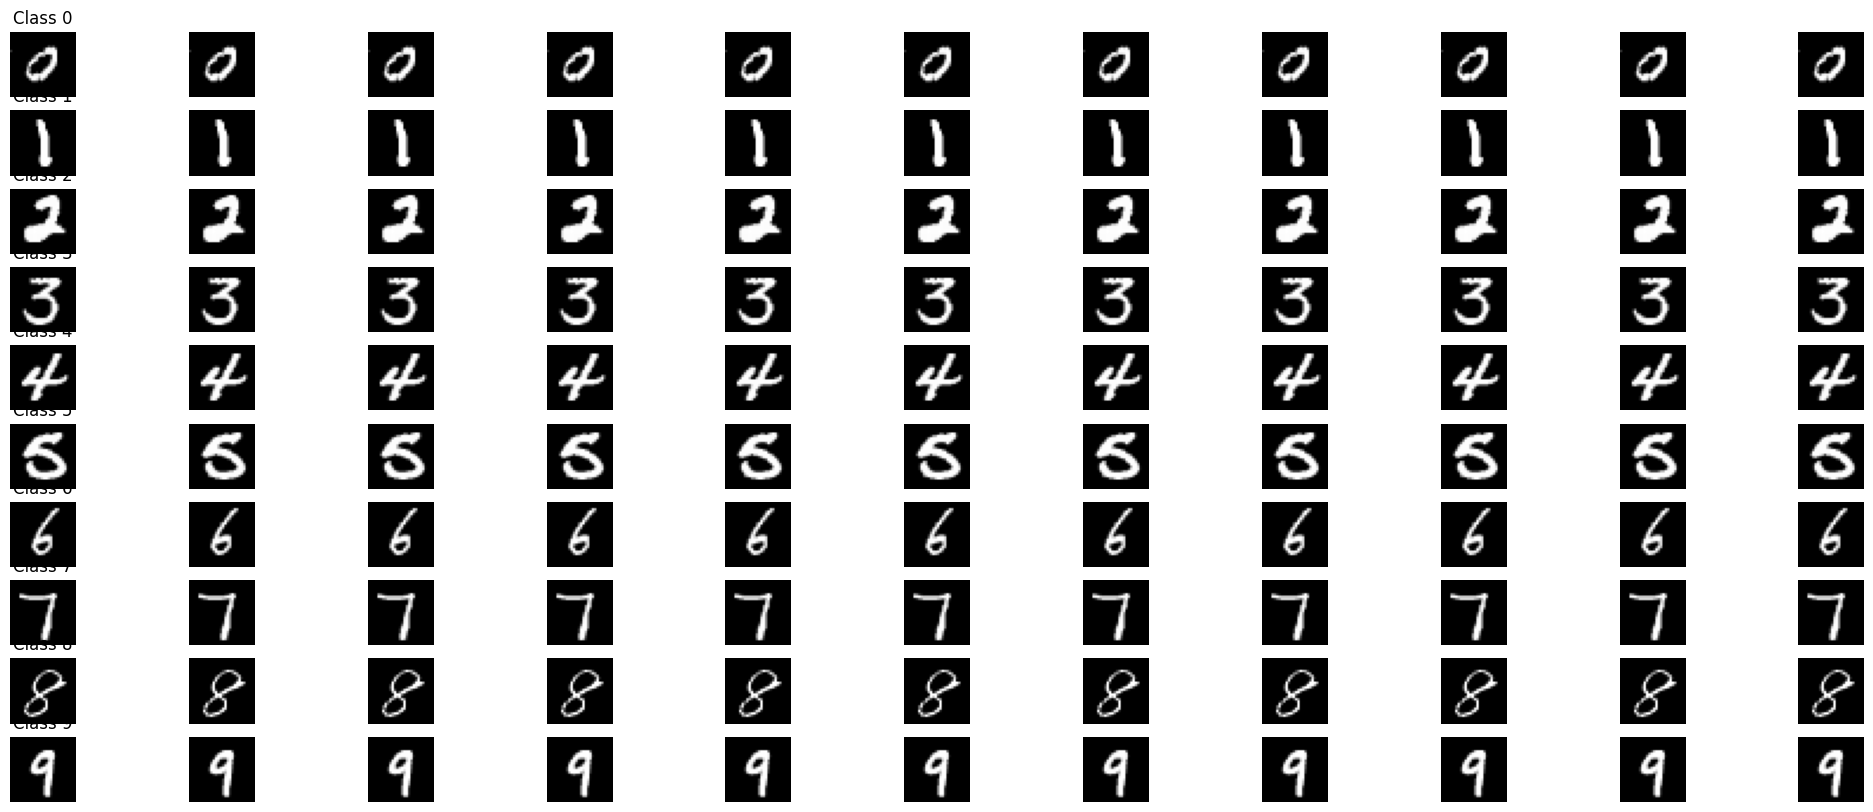

In [10]:
cfg = util.load_and_override_config(".", "config")
data_augmentation = util.get_data_augmentation_layers(cfg.data_augmentation)

import matplotlib.pyplot as plt
import tensorflow as tf

def plot_augmented_images_per_class(data_augmentation, x_train, y_train, num_classes=10):
    plt.figure(figsize=(25, 10))
    
    for class_idx in range(num_classes):
        # Get the first image of the current class
        class_images = x_train[y_train == class_idx]
        first_image = class_images[:1]
        
        # Plot the original image with no augmentation
        ax = plt.subplot(num_classes, 11, class_idx * 11 + 1)
        plt.imshow(first_image[0], cmap='gray')
        plt.title(f"Class {class_idx}")
        plt.axis("off")
        
        # Plot 10 augmented images
        for i in range(10):
            augmented_image = data_augmentation(first_image)
            ax = plt.subplot(num_classes, 11, class_idx * 11 + i + 2)
            plt.imshow(augmented_image[0], cmap='gray')
            plt.axis("off")
    
    plt.show()

# Assuming x_train and y_train are your training images and labels
plot_augmented_images_per_class(data_augmentation, x_train, y_train)
from numba import cuda

cuda.select_device(0)
cuda.close()

Save preprocessed data for training

In [11]:
# Make sure dir exists
os.makedirs(cfg.preprocessed_data_path, exist_ok=True)
# Save the data
np.save(cfg.x_train_path, x_train,)
np.save(cfg.y_train_path, y_train)
np.save(cfg.x_val_path, x_val)
np.save(cfg.y_val_path, y_val)
np.save(cfg.x_test_path, x_test)


In [12]:
# free memory
%who
%whos
gc.collect()
del data_augmentation
del x_train
del y_train
del x_val
del y_val
del x_test
del train_df
del test_df

gc.collect()

OmegaConf	 cfg	 classes	 cls	 competition_name	 cuda	 data_augmentation	 data_dir	 device	 
display	 gc	 i	 idx	 idxs	 kaggle	 keras	 layers	 n_classes	 
np	 os	 pd	 plot_augmented_images_per_class	 plt	 plt_idx	 samples_per_class	 test_df	 tf	 
time	 torch	 train_df	 train_test_split	 util	 wandb	 x_test	 x_train	 x_val	 
y	 y_train	 y_val	 zip_ref	 zipfile	 
Variable                          Type          Data/Info
---------------------------------------------------------
OmegaConf                         type          <class 'omegaconf.omegaconf.OmegaConf'>
cfg                               DictConfig    {'project_name': 'Day3', <...>e_range': [0.0, 1.0]}}}}}
classes                           ndarray       10: 10 elems, type `int64`, 80 bytes
cls                               int64         9
competition_name                  str           digit-recognizer
cuda                              module        <module 'numba.cuda' from<...>/numba/cuda/__init__.py'>
data_augmentation        

783

## Prepare sweep

In [13]:
sweep_configuration_yaml = """
name: data_augmentation_sweep
program: train.py
method: grid
metric:
    goal: maximize
    name: epoch/val_acc
parameters:
    data_augmentation.layers.RandomTranslation.kwargs.height_factor:
        values: [0, 0.1, 0.5]
    data_augmentation.layers.RandomTranslation.kwargs.width_factor:
        values: [0, 0.1, 0.5]
    data_augmentation.layers.RandomRotation.kwargs.factor:
        values: [0, 0.1, 0.5]
    data_augmentation.layers.RandomZoom.kwargs.height_factor:
        values: [0, 0.1, 0.5]
    data_augmentation.layers.RandomZoom.kwargs.width_factor:
        values: [0, 0.1, 0.5]
    data_augmentation.layers.RandomContrast.kwargs.factor:
        values: [0, 0.1, 0.5]
    data_augmentation.layers.RandomBrightness.kwargs.factor:
        values: [0, 0.1, 0.5]


  """
cfg = util.load_and_override_config(".", "config")
# Create an OmegaConf object from the YAML string
sweep_config = OmegaConf.create(sweep_configuration_yaml)

# Convert the OmegaConf object to a regular Python dictionary
wandb_sweep_config = OmegaConf.to_container(sweep_config, resolve=True)

# Ensure the dictionary is correctly formatted for wandb.sweep
wandb_sweep_config = dict(wandb_sweep_config)

# Print the converted configuration to verify
print(wandb_sweep_config)

# Initialize a Weights & Biases sweep with the configuration
sweep_id = util.get_or_create_sweep_id(cfg.project_name,wandb_sweep_config)
#wait for sweep to be created
time.sleep(5)



cfg: 
 {'project_name': 'Day3', 'username': 'frizzerdk', 'is_sweep': False, 'sweep_count': 1, 'preprocessed_data_path': './data/preprocessed', 'x_train_path': '${preprocessed_data_path}/x_train.npy', 'y_train_path': '${preprocessed_data_path}/y_train.npy', 'x_test_path': '${preprocessed_data_path}/x_test.npy', 'x_val_path': '${preprocessed_data_path}/x_val.npy', 'y_val_path': '${preprocessed_data_path}/y_val.npy', 'checkpoint_path': './checkpoints', 'best_model_path': '${checkpoint_path}/best_model.keras', 'num_classes': 10, 'input_shape': [28, 28, 1], 'activation': 'relu', 'epochs': 2, 'param_scale': 2.0, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64, 'patience': 20, 'data_augmentation': {'layers': {'RandomTranslation': {'kwargs': {'height_factor': 0.0, 'width_factor': 0.0, 'fill_mode': 'constant'}}, 'RandomRotation': {'kwargs': {'factor': 0.0, 'fill_mode': 'constant'}}, 'RandomZoom': {'kwargs': {'height_factor': 0.0, 'width_factor': 0.0, 'fill_mode': 'constant'}}, 'Ra

## Run training Script

In [14]:
# Define the tmux session name and the list of scripts to execute
tmux_session_name = "devenv_session"
is_sweep = True


if is_sweep: 
    #script = ["wandb agent -p Day3 -e frizzerdk --count 20 " + sweep_id] 
    sweep_count_string = " --count " +str(cfg.sweep_count) +" " if cfg.sweep_count>0 else " "
    script = ["wandb agent -p "+cfg.project_name+" -e "+cfg.username+sweep_count_string  + sweep_id] 
    n_repeats = 1
    # Repeat the scripts n_repeats times
    scripts = script * n_repeats
else:
    # Define the list of scripts to execute
    scripts = ["python3 train.py"] 

# Check if the session already exists
existing_sessions = !tmux ls 2> /dev/null
session_exists = any(tmux_session_name in session for session in existing_sessions)

# If the session exists, kill it
if session_exists:
    print(f"Session '{tmux_session_name}' already exists. Killing the session.")
    !tmux kill-session -t {tmux_session_name}

# Start a new tmux session i folder of current file
file_path = os.path.abspath("train.py")
print(f"Creating a new session: {tmux_session_name}")
!tmux new-session -d -s {tmux_session_name} -n main -c {os.path.dirname(file_path)}

# Select the first window
first_window_name = "main"

# Initialize the first pane with the first script
print(f"Running script {scripts[0]} in the first pane")
!tmux send-keys -t {tmux_session_name}:{first_window_name}.0 "{scripts[0]}" Enter

# For subsequent scripts, create a new pane and execute the script
for i, script in enumerate(scripts[1:], start=1):
    # sleep for 5 seconds to allow the previous script to start
    time.sleep(5)
    print(f"Creating pane {i} for script {script}")
    # Split the window to add a new pane
    !tmux split-window -t {tmux_session_name}:{first_window_name}
    # Send the command to execute the script in the new pane
    !tmux send-keys -t {tmux_session_name}:{first_window_name}.{i} "python3 {script}" Enter

# set main-pane-width
!tmux setw -t {tmux_session_name} main-pane-width 50%

# Apply a layout to distribute panes evenly
!tmux select-layout -t {tmux_session_name}:{first_window_name} main-vertical
#!:set -g mouse on


# Optional: Attach to the tmux session (commented for Jupyter notebook)
#tmux attach-session -t devenv_session


Creating a new session: devenv_session
Running script wandb agent -p Day3 -e frizzerdk --count 1 zc6bdzeq in the first pane


## Evalutate trained models

In [15]:
y_val = np.load(cfg.y_val_path)